---
#Google Drive

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---

#CHAPTER 7 앙상블 학습과 랜덤 포레스트

#7.5 부스팅(Boosting)



* 약한 학습기를 여려 개 연결하여 강한 학습기를 만드는 앙상블 방법
* 앞의 모델을 보완해 나가면서 일련의 예측기를 학습
>* 1) 에이다부스트(adaptive boosting의 줄임말) 또는 아다부스트
>* 2) 그레디언트 부스팅



#7.5.1 에이다부스트


*   이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여 다음 단계에서 다시 학습하는 방법(학습하기 어려운 샘플에 점점 더 일반화하는 방법)
*   에이다부스트는 앙상블에 예측기를 추가, 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습(단, 병렬화 불가능)
*   [참고] 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정

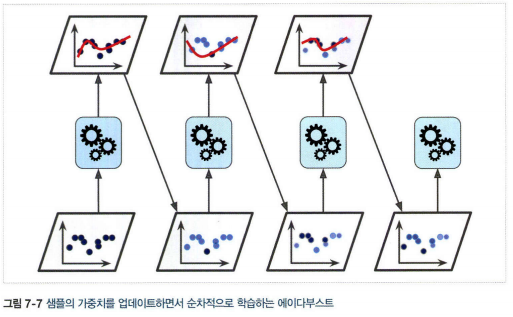

> 1) 기반이 되는 첫 번째 분류기를 훈련 데이터셋으로 훈련시키고 예측값 생성

> 2) 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임

> 3) 업데이트된 가중치를 사용해 두번째 분류기를 훈련세트로 훈련하고 다시 예측값 생성

> 4) 2~3과정 반복


* moons 데이터셋에 rbf 커널을 사용하는 SVC 모델 적용
* 5번 연속으로 학습한 결과

In [26]:
# moons dataset을 이용
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

m =  375
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 2. 1. 1. 2.]
[1. 1. 1. 1. 1. 1. 4. 1. 1. 2.]
[1. 2. 1. 1. 1. 1. 4. 1. 1. 2.]
[2. 4. 1. 1. 1. 1. 4. 1. 1. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.  1.  1.  1.  1.  1.  1.5 1.  1.  1.5]
[1.   1.   1.   1.   1.   1.   2.25 1.   1.   1.5 ]
[1.    1.    1.    1.    1.    1.    3.375 1.    1.    1.5  ]
[1.     1.5    1.     1.     1.     1.     5.0625 1.     1.     1.5   ]


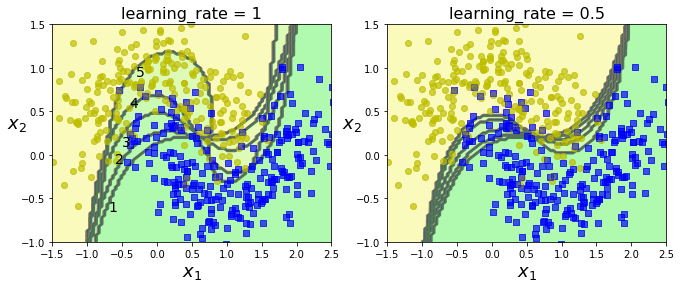

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
  # 100개 포인트
  x1s = np.linspace(axes[0], axes[1], 100)
  x2s = np.linspace(axes[2], axes[3], 100) 
  # 그리드 포인트
  x1, x2 = np.meshgrid(x1s, x2s) 
  X_new = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X_new).reshape(x1.shape)
  # 색
  custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
  if contour:
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
  # 선    
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
  plt.axis(axes)
  plt.xlabel(r"$x_1$", fontsize=18)
  plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

m = len(x_train)
print('m = ', m)  

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
  # 처음 가중치는 모두 1
  sample_weights = np.ones(m)
  plt.subplot(subplot)
  
  # 5개의 연속된 SVM분류기의 Adaboost모델을 for문을 통해 수동적으로 가중치를 더해가는 코드
  for i in range(5):
    
    # 분류기 생성, 커널은 rbf(radial basis function, 방사형 기저 함수)
    # 예측 변수의 값을 기준으로 하나 이상의 종속(대상) 변수에 대한 예측 모형을 생성
    svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
    
    # SVM분류기에 훈련 데이터를 다시 fit할때 sample_weight옵션에 업데이트된 가중치를 부여
    svm_clf.fit(x_train, y_train, sample_weight = sample_weights)
    y_pred = svm_clf.predict(x_train)

    # 가중치가 더해가는 과정 출력, 10개만
    print(sample_weights[:10])  
    
    # 가중치 조절
    # (y_pred != y_train)샘플에 대하여 (1+learning_rate) 곱
    sample_weights[y_pred != y_train] *= (1 + learning_rate) 
    plot_decision_boundary(svm_clf, x, y, alpha=0.2)
    plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
  if subplot == 121:
    plt.text(-0.7, -0.65, "1", fontsize=14)
    plt.text(-0.6, -0.10, "2", fontsize=14)
    plt.text(-0.5, 0.10, "3", fontsize=14)
    plt.text(-0.4, 0.55, "4", fontsize=14)
    plt.text(-0.3, 0.90, "5", fontsize=14)

plt.show()

>  * 첫번째부터 다섯번째까지 학습을 진행할수록 더 정확하게 분류
>  * learning_rate이 1보다는 0.5인 경우가 더 일반화가 가능한 결과

>  * [참고]
>  * 경사하강법은 cost function을 최소화하도록 예측기 파라미터 조정
>  * 아다부스트는 예측이 더 정확해지도록 앙상블에 가중치를 조정

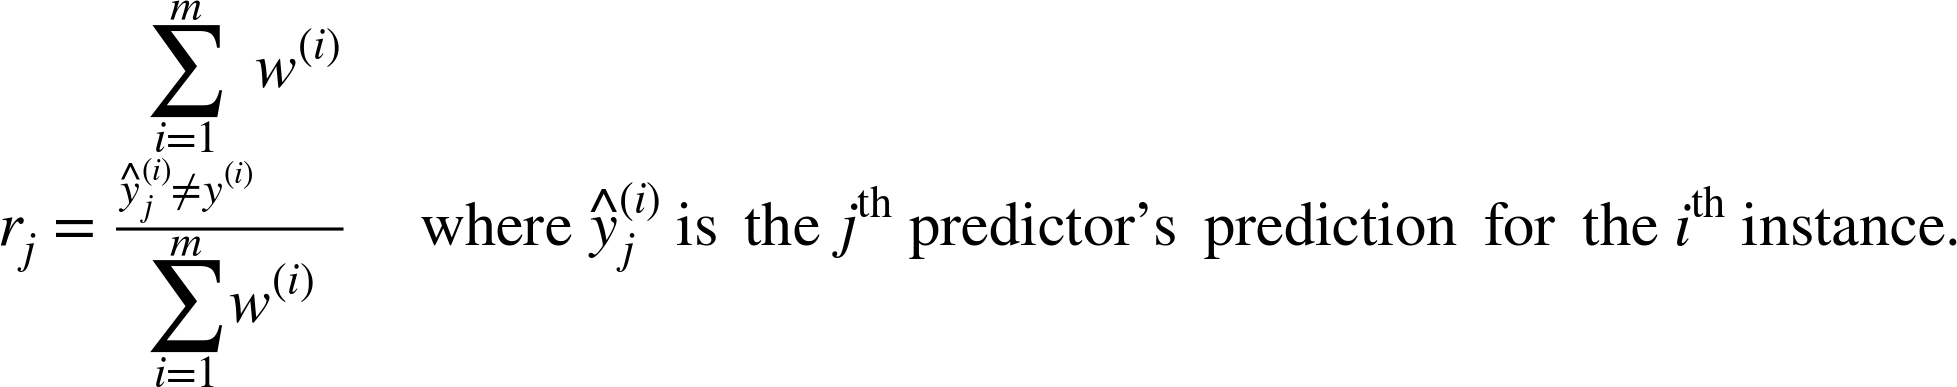

* 위 식을 이용해 가중치가 적용된 에러율이 훈련세트에 대해 계산

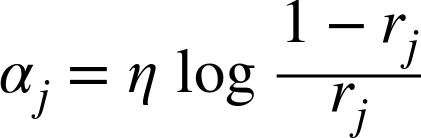

* 지정된 예측기의 수에 도달하거나 완벽한 예측기가 제작되면 중단

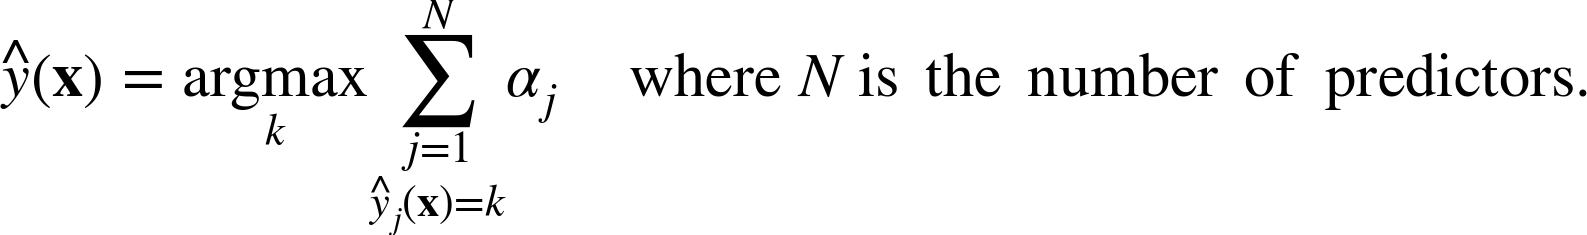



*   배깅이나 페이스팅과 비슷한 방식으로 예측을 만들지만, 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용

> [참고] 배깅, 페이스팅
> - 훈련세트에서 중복을 허용하여 샘플링하는 방식을 배깅(bagging, bootstrap aggregating),  
> - 중복을 허용하지 않고 샘플링하는 방식을 페이스팅(pasting)

*   사이킷런의 에이다부스트
> *   분류 모델: AdaBoostClassifier
> *   회귀 모델: AdaBoostRegressor

>> * 사이킷런은 SAMME라는 아다부스트의 다중 범주 버전을 사용한다. 범주가 2개(이진분류)라면 SAMMEE가 아다부스트와 동일

* 간단한 예로 결정트리를 기반으로 회귀문제
* 노이즈가 섞인 2차곡선 형태의 훈련세트를 생성

In [28]:
# 예제: 에이다 부스트 + 의사결정나무
# moons 데이터셋에 의사결정나무 사용
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# AdaBoostClassifier의 기본 추정기
# SAMME.R : 가중치 계산 알고리즘, real 다중범주, 확률기반
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                             algorithm="SAMME.R", learning_rate=0.5) 
ada_clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

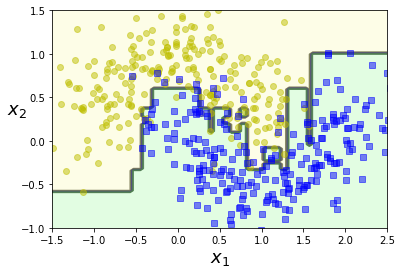

In [29]:
plot_decision_boundary(ada_clf, x, y)

#7.5.2 그레디언트 부스팅

*   이전 학습기에 의한 오차를 보정하도록 새로운 예측기를 순차적으로 추가하는 
아이디어는 에이다부스트와 동일
*  샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔차(residual error)에 대해 새로운 예측기를 학습시킴
*   잔차(residual error): 예측값과 실제값 사이의 오차

* 사이킷런 그레이디언트 부스팅 모델
>  * 분류 모델: GradientBoostingClassifier
>> RandomForestClassifier와 비슷한 하이퍼파라미터를 제공
>  * 회귀 모델: GradientBoostingRegressor
>> RandomForestRegressor와 비슷한 하이퍼파라미터를 제공

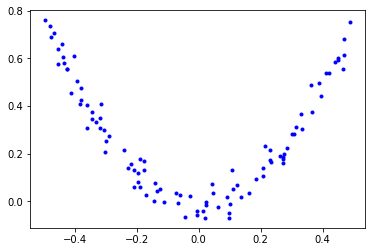

In [30]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

plt.plot(X,y, "b.")
plt.show()

* 그레디언트 트리 부스팅 또는 * 그레이디언트 부스티드 회귀 나무(GBRT)
* 예제: 그레이디언트 부스팅 (회귀)+ 의사결정나무
>  * 2차 다항식 데이터셋에 의사결정나무 3개를 적용한 효과와 동일하게 작동

In [31]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [32]:
# 첫 번째 예측기에서 생긴 잔여 오차(y2)에 두번째 예측기를 훈련
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [33]:
# 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

* 이제 세개의 트리를 포함하는 앙상블 모델을 만들었으니, 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더함

In [18]:
X_new = np.array([[0.8]]) # 새로운 샘플 0.8
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

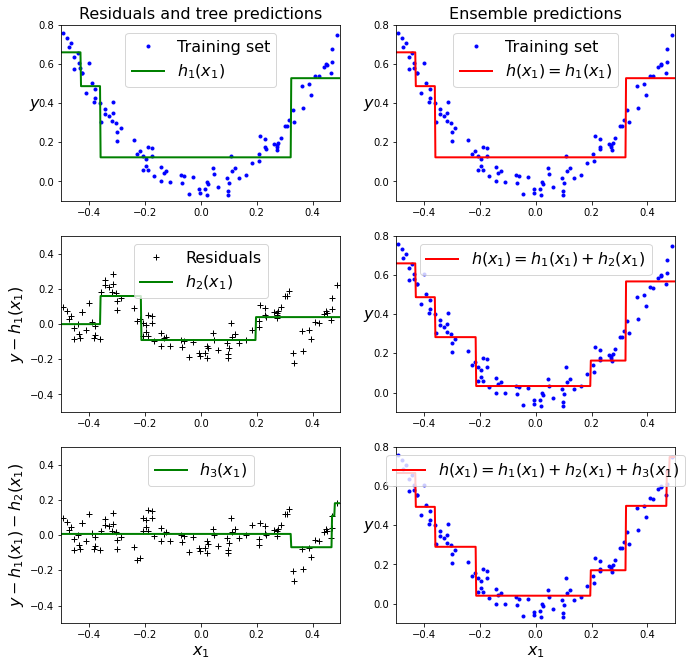

In [34]:
# 구한 개별 예측기와 앙상블 모델에 대해 시각화
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()    

* 왼쪽열은 세개의 트리에 대한 개별 예측이고, 오른쪽열은 각각의 예측기의 잔여오차로 재학습하여 예측값을 더한 앙상블모델

In [35]:
# 이러한 과정을 그래디언트 부스티드 회귀트리(Gradient Boosted Regression Tree, GBRT)
# 사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련
from sklearn.ensemble import GradientBoostingRegressor

# n_estimators : 트리 수(즉, 반복 수)
# max_depth : 트리의 깊이(노드 수)
# learning_rate : 학습률
gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0,
                                 random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [37]:
gbrt_slow = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=200,
                                      learning_rate=0.1,
                                      random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

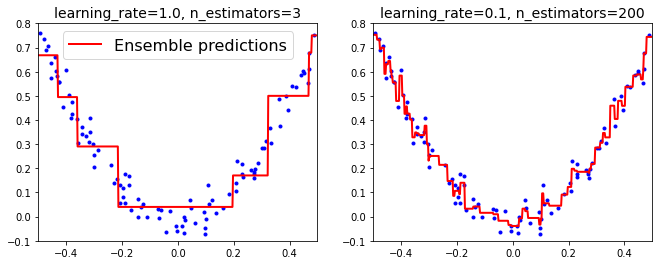

In [38]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

* 예측기가 부족한 경우(왼쪽), 예측기가 너무 많은 경우(오른쪽) GBRT 앙상블

* staged_predict()메서드를 사용해 최적의 트리 수를 구할 수 있음

In [39]:
# 120개의 트리로 GBRT앙상블을 훈련
# 최적의 트리 수를 찾기위해 각 훈련단계에서 검증 오차를 측정
# 최적의 트리 수를 구하고 최종 GBRT 앙상블을 훈련
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2,
                                n_estimators= 120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
# np.argim(array) : array에서 최솟값의 인덱스를 반환
# 즉, 최소값을 갖게하는 인덱스로 최적 트리의 수를 판단

gbrt_best = GradientBoostingRegressor(max_depth=2,
                                     n_estimators=bst_n_estimators,
                                     random_state=42)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=68,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

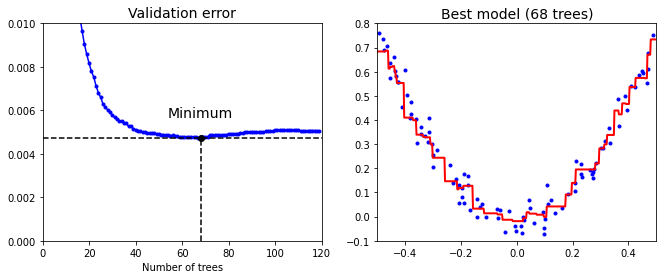

In [40]:
# 검증오차를 통해 최솟값을 찾은 것과, 최적의 트리 수 찾아 훈련한 앙상블 모델을 시각화
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
# y 수직선 0~0.004 (x는 83위치)

plt.plot([0, 120], [min_error, min_error], "k--")
# x 수평선 0~120 (y는 min_error위치, 0.004)

plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

* 왼쪽은 검증 오차, 오른쪽은 최적 앙상블 모델의 예측

* 120개의 트리를 모두 훈련시키고 최적의 수를 찾기위해 검증오차를 분석하는 대신, "조기 종료"를 이용 -> 확률적 그레디언트 부스팅

In [41]:
# warm_start=True로 설정, fit()메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가
# 연속해서 다섯번의 반복동안 검증오차가 향상되지 않으면 훈련을 멈추는 과정
X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth = 2,
                                warm_start=True,   # 기존 트리를 유지
                                random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators   # 트리 수 입력
    gbrt.fit(X_train, y_train)         # 훈련
    y_pred = gbrt.predict(X_val)       # 예측값 생성
    val_error = mean_squared_error(y_val, y_pred)  # MSE 계산
    if val_error < min_val_error:      # 초기 min_val_error는 무한대(inf)
        min_val_error = val_error      
        error_going_up = 0
    else:
        error_going_up += 1            # 누적
        if error_going_up == 5:        # 연속해서 5번이나 MSE가 기존보다 크면
            break                      # 조기 종료

print("최적의 트리 수 :", n_estimators)
print("최적일 때의 MSE :", min_val_error)

# 참고로...
# GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 subsample옵션으로 지정 가능
# 예: subsample=0.25라고 지정하면 트리는 무작위로 선택된 25%의 훈련 샘플로 학습

최적의 트리 수 : 72
최적일 때의 MSE : 0.0028209980081892543


#확률적 그레디언트 부스팅
* 각 의사결정나무가 훈련에 사용할 훈련 샘플의 비율을 지정하여 학습
속도 빠름
* 편향 높아지지만, 분산 낮아짐.

* 최적화된 그레디언트 부스팅 구현으로 XGBoost 파이썬 라이브러리가 유명

#XGBoost
* Extreme Gradient Boosting의 줄임말
* 빠른 속도, 확장성, 이식성 뛰어남
* 사이킷런과 비슷한 API 제공
* 조기종료 등 다양한 기능 제공

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X,y)

import xgboost
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)  

[11:09:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.001621348255337682


In [43]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)  

[11:09:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.316856
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.292622
[2]	validation_0-rmse:0.270009
[3]	validation_0-rmse:0.250637
[4]	validation_0-rmse:0.231969
[5]	validation_0-rmse:0.2154
[6]	validation_0-rmse:0.199893
[7]	validation_0-rmse:0.186305
[8]	validation_0-rmse:0.174249
[9]	validation_0-rmse:0.162876
[10]	validation_0-rmse:0.152553
[11]	validation_0-rmse:0.141729
[12]	validation_0-rmse:0.132121
[13]	validation_0-rmse:0.124155
[14]	validation_0-rmse:0.117555
[15]	validation_0-rmse:0.109695
[16]	validation_0-rmse:0.102582
[17]	validation_0-rmse:0.095982
[18]	validation_0-rmse:0.090237
[19]	validation_0-rmse:0.085562
[20]	validation_0-rmse:0.081492
[21]	validation_0-rmse:0.077905
[22]	validation_0-rmse:0.075021
[23]	validation_0-rmse:0.071597
[24]	validation_0-rmse:0.06827
[25]	validation_0-rmse